In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pickle

import numpy as np
#import ROVClass as ROVC
from sympy.parsing.sympy_parser import parse_expr
from sympy import *

# Se importa el modelo matematico y se transforma de string a Scipy

Modelo = {}
archivo = open("Modelo_Matematico_ecuaciones.txt", "r")
listt = archivo.readlines()
Modelo["VCMas"] = parse_expr(listt[0], evaluate=False)
Modelo["VCMenos"] = parse_expr(listt[1], evaluate=False)
Modelo["ndot"] = parse_expr(listt[2], evaluate=False)
Modelo["JInv"] = parse_expr(listt[3], evaluate=False)
archivo.close()

In [5]:
class DataROV:
    def __init__(self,SystemControlRov):
        self.Kp_n = SystemControlRov.Kp_n
        self.Ki_n = SystemControlRov.Ki_n
        self.Kd_n = SystemControlRov.Kd_n
        self.Kp_v = SystemControlRov.Kp_v
        self.Ki_v = SystemControlRov.Ki_v
        self.Kd_v = SystemControlRov.Kd_v
        self.t = SystemControlRov.t 
        self.dt = SystemControlRov.dt 
        self.Modelo = SystemControlRov.Modelo
        self.Referencia = SystemControlRov.Referencia
        self.Inv = SystemControlRov.Modelo["JInv"]
        self.Vdot = SystemControlRov.Vdot
        self.ndot = SystemControlRov.ndot
        self.errorVActual = SystemControlRov.errorVActual
        self.errornActual = SystemControlRov.errornActual
        
        self.VValues = SystemControlRov.VValues
        self.nValues = SystemControlRov.nValues
        self.VdotValues = SystemControlRov.VdotValues
        self.ndotValues = SystemControlRov.ndotValues
        self.errorn = SystemControlRov.errorn
        self.errorV = SystemControlRov.errorV
        self.torque = SystemControlRov.torque

class SystemControlRov:
    USym= np.array([symbols('u1'), symbols('u2'), symbols('u3'), symbols('u4'), symbols('u5'), symbols('u6')]) # Se define el vector de entradas
    VSym = np.array([symbols('u'),symbols('v'),symbols('w'),symbols('p'),symbols('q'),symbols('r')])
    nSym = np.array([symbols('x'),symbols('y'),symbols('z'),symbols('phi'),symbols('theta'),symbols('psi')])
    tsym = symbols("t") 
    MTrans = np.array([[ 391.7554 ,10955.212 ,-5661.8977 ,304358.4124 , 95976.6584,       0     ],
                       [ 391.7554 ,-10955.212,-5661.8977 ,-304358.4124, 95976.6584,       0     ],
                       [-1164.7727,       0  ,-12942.7506,     0      ,-285359.172,       0     ],
                       [13609.9585,1274.7187 ,     0     ,     0      ,     0     ,-420545.0263 ],
                       [13609.9585,-1274.7187,     0     ,     0      ,     0     , 420545.0263 ],
                       [       0  ,35082.3045,     0     ,     0      ,     0     ,       0     ]])
    Ok = True
    Vmax = np.array([0.5,0.5,0.3,0.1,20,20])
    NFigures = 1
    #Inicializa El modelo
    def __init__(self,Modelo,Referencia,t,dt,Kp_n,Kp_v,Ki_n=0,Ki_v=0,Kd_n=0,Kd_v=0):
        self.Kp_n = Kp_n
        self.Ki_n = Ki_n
        self.Kd_n = Kd_n
        self.Kp_v = Kp_v
        self.Ki_v = Ki_v
        self.Kd_v = Kd_v
        self.t = t 
        self.dt = dt 
        self.Modelo = Modelo
        self.Referencia = Referencia
        self.Inv = Modelo["JInv"]
        self.Vdot = np.zeros(6)
        self.ndot = np.zeros(6)
        self.errorVActual = np.zeros(6)
        self.errornActual = np.zeros(6)
        
        self.VValues = np.empty((t.size,6))
        self.nValues = np.empty((t.size,6))
        self.VdotValues = np.empty((t.size,6))
        self.ndotValues = np.empty((t.size,6))
        self.errorn = np.empty((t.size,6))
        self.errorV = np.empty((t.size,6))
        self.torque = np.empty((t.size,6))

    #Resuelve Ecuaciones apartir de Velocidades, posiciones y entrada (Esta es la planta)
    def ResolvEcuations(self,V_ant,n_ant,U_Actual): #Retorna acelaraciones locales y velocidades inerciales
        Values = []
        
        for i in range(6):
            Values.append((self.VSym.item(i),V_ant.item(i))) #Agrega tupla de (symbolo valor)   
            Values.append((self.nSym.item(i),n_ant.item(i))) #Agrega tupla de (symbolo valor)
            Values.append((self.USym.item(i),U_Actual.item(i)))     #Agrega tupla de (symbolo valor)

        _Vdot = np.empty(6)
        _ndot = np.empty(6)
        for i in range(6):
            _ndot[i] = self.Modelo["ndot"][i].subs(Values)
            _Vdot[i] = self.Modelo["VCMas"][i].subs(Values)
           

        return [_Vdot*self.dt,_ndot*self.dt,]
    
    def ResolveJInv(self,Matriz,n_actual):
        Values = []
        for i in range(6):
            Values.append((self.nSym.item(i),n_actual.item(i))) #Agrega tupla de (symbolo valor)
        Resultado = np.empty([6,6]) 
        for i in range(6):
            for j in range(6):
                #print(Matriz[i][j].subs(Values))
                Resultado[i][j] = Matriz[i][j].subs(Values)
        return Resultado

    #Resuelve el sistema a partir del modelo, los parametros de la matriz controladora y el controlador.... 
    def ResolvSistem(self):
        P_n = np.zeros(6)
        I_n = np.zeros(6)
        D_n = np.zeros(6)

        error_Posicion = np.zeros(6)
        error_Posicion_PID = np.zeros(6)


        Referencia_v = np.zeros(6)

        P_v = np.zeros(6)
        I_v = np.zeros(6)
        D_v = np.zeros(6)

        error_Velocidad = np.zeros(6)
        error_Velocidad_PID = np.zeros(6)


        errorU =  np.zeros(6)


        VActual = np.zeros(6)
        nActual = np.zeros(6)
        
        
        for i in range(self.t.size):
            # Calcula error
            P_n = self.Kp_n*error_Posicion
            I_n += self.Ki_n*error_Posicion
            D_n = self.Kd_n*((self.Referencia[i] - nActual) - error_Posicion)/self.dt
                        
            error_Posiciondot = ((self.Referencia[i] - nActual) - error_Posicion)/self.dt

            error_Posicion = self.Referencia[i] - nActual
            error_Posicion_PID = P_n + I_n + D_n
            aja = self.ResolveJInv( self.Inv ,nActual) 
            Referencia_v =np.dot(aja,error_Posiciondot)
            #Referencia_v = np.dot(  aja ,  error_Posiciondot   )
            P_v = self.Kp_v*error_Velocidad
            I_v += self.Ki_v*error_Velocidad
            D_v = self.Kd_v*((Referencia_v - VActual) - error_Velocidad)/self.dt
            
            error_Velocidad = Referencia_v - VActual
            error_Velocidad_PID = P_n + I_n + D_n
            #if(  (error_Velocidad_PID > self.Vmax).any()  ):
            #    error_Velocidad_PID = (error_Velocidad_PID > self.Vmax) * self.Vmax + (error_Velocidad_PID < self.Vmax) * error_Velocidad_PID
            
            errorU =  np.dot(self.MTrans,error_Velocidad_PID)

            Vdot,ndot = self.ResolvEcuations(VActual,nActual,errorU) #Soluciona ecuacion 
            
            if((Vdot > np.ones(6)*1000).any()):
                self.Ok = False
                return
            elif((Vdot < -np.ones(6)*1000).any()):
                self.Ok = False
                return
            VActual += Vdot
            nActual += ndot

            #LLena valores de array
            self.VValues[i] = VActual
            self.nValues[i] = nActual
            self.VdotValues[i] = Vdot
            self.ndotValues[i] = ndot
            self.errorV[i] = error_Velocidad
            self.errorn[i] = error_Posicion

            self.torque[i] = errorU    
       
    def Graficar(self,Mostrar,Legend = "lower center",size_imagen = [15,5]):
        Graficas= {"Udot": plt.plot(self.t,self.VdotValues.transpose()[0],label='Udot'),
                  "Vdot": plt.plot(self.t,self.VdotValues.transpose()[1],label='Vdot'),
                  "Wdot": plt.plot(self.t,self.VdotValues.transpose()[2],label='Wdot'),
                  "Pdot": plt.plot(self.t,self.VdotValues.transpose()[3],label='Pdot'),
                  "Qdot": plt.plot(self.t,self.VdotValues.transpose()[4],label='Qdot'),
                  "Rdot": plt.plot(self.t,self.VdotValues.transpose()[5],label='Rdot'),
                  
                  "Xdot": plt.plot(self.t,self.VdotValues.transpose()[0],label='Xdot'),
                  "Ydot": plt.plot(self.t,self.VdotValues.transpose()[1],label='Ydot'),
                  "Zdot": plt.plot(self.t,self.VdotValues.transpose()[2],label='Zdot'),
                  "Phidot": plt.plot(self.t,self.VdotValues.transpose()[3],label='Φdot'),
                  "Thetadot": plt.plot(self.t,self.VdotValues.transpose()[4],label='θdot'),
                  "Psidot": plt.plot(self.t,self.VdotValues.transpose()[5],label='Ψdot'),
                   
                  "U": plt.plot(self.t,self.VValues.transpose()[0],label='U'),
                  "V": plt.plot(self.t,self.VValues.transpose()[1],label='V'),
                  "W": plt.plot(self.t,self.VValues.transpose()[2],label='W'),
                  "P": plt.plot(self.t,self.VValues.transpose()[3],label='P'),
                  "Q": plt.plot(self.t,self.VValues.transpose()[4],label='Q'),
                  "R": plt.plot(self.t,self.VValues.transpose()[5],label='R'),
                  
                  "X": plt.plot(self.t,self.nValues.transpose()[0],label='X'),
                  "Y": plt.plot(self.t,self.nValues.transpose()[1],label='Y'),
                  "Z": plt.plot(self.t,self.nValues.transpose()[2],label='Z'),
                  "Phi": plt.plot(self.t,self.nValues.transpose()[3],label='Φ'),
                  "Theta": plt.plot(self.t,self.nValues.transpose()[4],label='θ'),
                  "Psi": plt.plot(self.t,self.nValues.transpose()[5],label='Ψ'),
                  "Referencia": plt.plot(self.t,self.Referencia.transpose()[0],label='Referencia')}
        
        plt.figure(self.NFigures, figsize = size_imagen)
        for i in Mostrar:
            Graficas[i]
        plt.legend(loc=Legend)
        self.NFigures += 1
    
    def Graficar(self):
        plt.figure(1, figsize = [15,20])

        plt.subplot(411)
        #plt.plot(t,u0,label='Impulso')
        plt.plot(self.t,self.VdotValues.transpose()[0],label='Udot')
        plt.plot(self.t,self.VdotValues.transpose()[1],label='Vdot')
        plt.plot(self.t,self.VdotValues.transpose()[2],label='Wdot')
        plt.plot(self.t,self.VdotValues.transpose()[3],label='Pdot')
        plt.plot(self.t,self.VdotValues.transpose()[4],label='Qdot')
        plt.plot(self.t,self.VdotValues.transpose()[5],label='Rdot')
        plt.legend(loc='upper center')

        plt.subplot(412)
        #plt.plot(t,U1,label='Impulso')
        plt.plot(self.t,self.VValues.transpose()[0],label='U')
        plt.plot(self.t,self.VValues.transpose()[1],label='V')
        plt.plot(self.t,self.VValues.transpose()[2],label='W')
        plt.plot(self.t,self.VValues.transpose()[3],label='P')
        plt.plot(self.t,self.VValues.transpose()[4],label='Q')
        plt.plot(self.t,self.VValues.transpose()[5],label='R')
        plt.legend(loc='lower left')


        plt.subplot(413)
        #plt.plot(t,u0,label='Impulso')
        plt.plot(self.t,self.ndotValues.transpose()[0],label='Xdot')
        plt.plot(self.t,self.ndotValues.transpose()[1],label='Ydot')
        plt.plot(self.t,self.ndotValues.transpose()[2],label='Zdot')
        plt.plot(self.t,self.ndotValues.transpose()[3],label='Φdot')
        plt.plot(self.t,self.ndotValues.transpose()[4],label='θdot')
        plt.plot(self.t,self.ndotValues.transpose()[5],label='Ψdot')
        plt.legend(loc='lower center')

        plt.subplot(414)
        plt.plot(self.t,self.nValues.transpose()[0],label='X')
        plt.plot(self.t,self.nValues.transpose()[1],label='Y')
        plt.plot(self.t,self.nValues.transpose()[2],label='Z')
        plt.plot(self.t,self.nValues.transpose()[3],label='Φ')
        plt.plot(self.t,self.nValues.transpose()[4],label='θ')
        plt.plot(self.t,self.nValues.transpose()[5],label='Ψ')
        plt.plot(self.t,self.Referencia.transpose()[0],label='Referencia')
        plt.legend(loc='lower center')
        
        plt.figure(2, figsize = [15,10])
        plt.subplot(311)
        plt.plot(self.t,self.errorV.transpose()[0],label='eu')
        plt.plot(self.t,self.errorV.transpose()[1],label='ev')
        plt.plot(self.t,self.errorV.transpose()[2],label='ew')
        plt.plot(self.t,self.errorV.transpose()[3],label='ep')
        plt.plot(self.t,self.errorV.transpose()[4],label='eq')
        plt.plot(self.t,self.errorV.transpose()[5],label='er')
        plt.legend(loc='lower center')
        
        plt.subplot(312)
        plt.plot(self.t,self.errorn.transpose()[0],label='ex')
        plt.plot(self.t,self.errorn.transpose()[1],label='ey')
        plt.plot(self.t,self.errorn.transpose()[2],label='ez')
        plt.plot(self.t,self.errorn.transpose()[3],label='ephi')
        plt.plot(self.t,self.errorn.transpose()[4],label='etheta')
        plt.plot(self.t,self.errorn.transpose()[5],label='epsi')
        plt.legend(loc='lower center')
        
        plt.subplot(313)
        plt.plot(self.t,self.torque.transpose()[0],label='u1')
        plt.plot(self.t,self.torque.transpose()[1],label='u2')
        plt.plot(self.t,self.torque.transpose()[2],label='u3')
        plt.plot(self.t,self.torque.transpose()[3],label='u4')
        plt.plot(self.t,self.torque.transpose()[4],label='u5')
        plt.plot(self.t,self.torque.transpose()[5],label='u5')
        plt.legend(loc='lower center')
    
    def Save(self,Archivo):
        Data = "{}|{}|{}|{}|{}|{}|{}|{}|{}|{}|{}|{}|{}|{}|{}\n".format(self.Kp_n, self.Ki_n, self.Kd_n, self.Kp_v, self.Ki_v, self.Kd_v, self.VdotValues.tolist(), self.VValues.tolist(), self.ndotValues.tolist(), self.nValues.tolist(), self.errorV.tolist(), self.errorn.tolist(), self.torque.tolist(), self.t.tolist(), self.dt )
        Archivo.write(Data)

In [6]:
with open("obj.pickle", "rb") as f:
    obj = pickle.load(f)


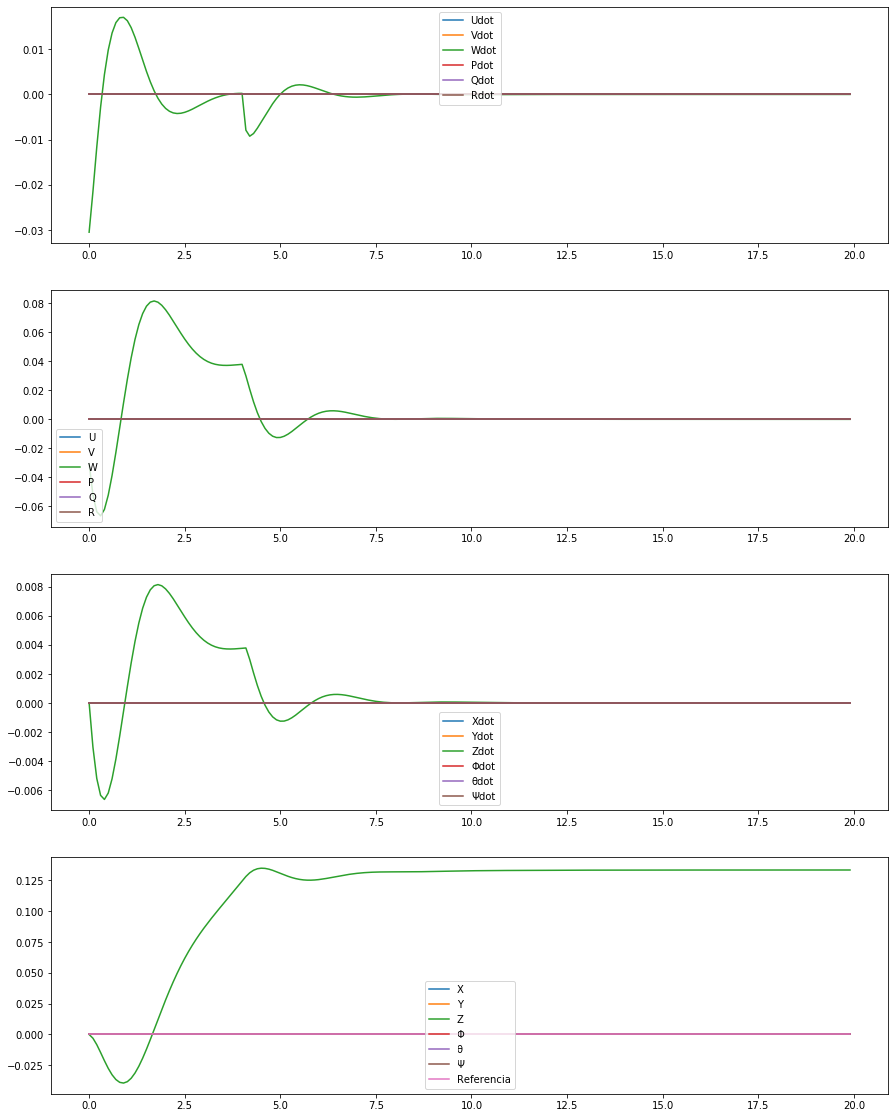

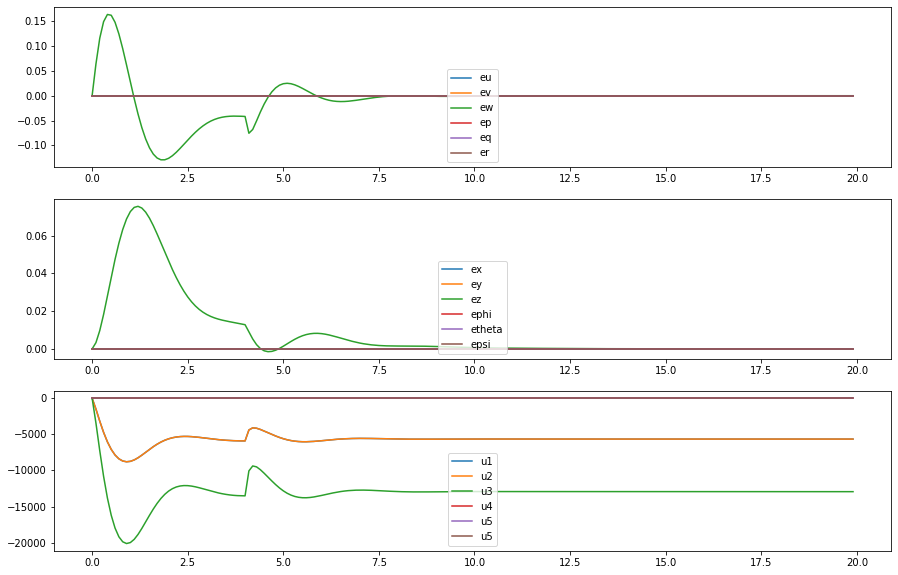

In [11]:
obj[60].Graficar()
